In [24]:
from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import random
import os
import cv2
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import albumentations as A
from numpy._core.defchararray import join, mod
import  torch.nn as nn
from torch._C import device
import torch.optim as optim
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.utils.data import random_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms as torchtrans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
def img_show(number : int, title : str = None, size : int = 5):

    root = "/content/drive/MyDrive/Coloab Expt/"
    image = cv2.imread(root + "Images/" + str(number) + ".jpeg")
    file = open(root + "Labels/" + str(number) + ".txt", 'r')
    txt_data = file.readlines()
    file.close()

    for i in range(0, int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0], indices[1])
        end_point = (indices[2], indices[3])

        cv2.rectangle(image, start_point, end_point, color = (0,0,255), thickness = 2)

    aspect_ratio = image.shape[0] / image.shape[1]

    plt.figure(figsize = (size + aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB ))
    plt.title(title + txt_data[0])
    plt.show()

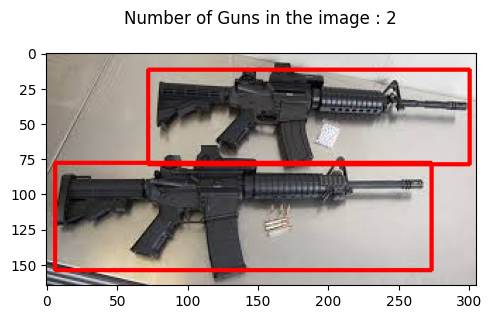

In [6]:
img_show(119, "Number of Guns in the image : ")

In [7]:
class GunData(Dataset):
    def __init__(self, root):

        self.image_path = root + "Images/"
        self.labels_path = root + "Labels/"
        self.img_name = [img for img in sorted(os.listdir(self.image_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self,idx):
        image_path =  os.path.join(self.image_path , str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).permute(2,0,1)

        label_name  = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path , str(label_name))

        with open(label_path,"r") as label_file:
            l_count = int(label_file.readline())
            box=[]
            for i in range(l_count):
                box.append(list(map(int,label_file.readline().split())))

        target={}
        area=[]
        labels=[]

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] -  box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] =  torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels , dtype=torch.int64)

        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key] , torch.Tensor):
                target[key] = target[key].to(device)

        return img_res,target

    def __len__(self):
        return len(self.img_name)

In [8]:
class Model:

    def __init__(self, num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model  = fasterrcnn_resnet50_fpn(pretrained = True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)

        return model

    def compiler(self, optimezer):
        self.optimizer = optimezer

    def train(self, train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model = self.model.to(device)
            train_loss = 0
            self.model.train()

            for img, target in train_data:
                loss_dict = self.model(img, target)
                loss = sum(loss for loss in loss_dict.values())

                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()
                train_loss += loss

            print(f"Epoch : {epoch+1} | Train loss :  {train_loss}")



In [9]:
rcnn = Model(2)
model = rcnn.model
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epoch = 30
rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))


dataset = GunData('/content/drive/MyDrive/Coloab Expt/')
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset , val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = 3, shuffle = True, num_workers = 0, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size = 3, shuffle = False, num_workers = 0, collate_fn = collate_fn)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 204MB/s]


In [10]:
rcnn.train(train_loader, val_loader)

  3%|▎         | 1/30 [03:38<1:45:22, 218.03s/it]

Epoch : 1 | Train loss :  22.277629852294922


  7%|▋         | 2/30 [05:03<1:05:20, 140.04s/it]

Epoch : 2 | Train loss :  16.05721092224121


 10%|█         | 3/30 [06:28<51:40, 114.85s/it]  

Epoch : 3 | Train loss :  13.768117904663086


 13%|█▎        | 4/30 [07:52<44:35, 102.92s/it]

Epoch : 4 | Train loss :  11.884645462036133


 17%|█▋        | 5/30 [09:17<40:11, 96.45s/it] 

Epoch : 5 | Train loss :  11.389364242553711


 20%|██        | 6/30 [10:42<37:00, 92.51s/it]

Epoch : 6 | Train loss :  9.647472381591797


 23%|██▎       | 7/30 [12:07<34:28, 89.93s/it]

Epoch : 7 | Train loss :  9.00497817993164


 27%|██▋       | 8/30 [13:31<32:17, 88.05s/it]

Epoch : 8 | Train loss :  7.517214298248291


 30%|███       | 9/30 [14:54<30:18, 86.59s/it]

Epoch : 9 | Train loss :  6.396218776702881


 33%|███▎      | 10/30 [16:19<28:41, 86.09s/it]

Epoch : 10 | Train loss :  6.07259464263916


 37%|███▋      | 11/30 [17:43<27:02, 85.42s/it]

Epoch : 11 | Train loss :  5.933328628540039


 40%|████      | 12/30 [19:08<25:36, 85.36s/it]

Epoch : 12 | Train loss :  5.459644317626953


 43%|████▎     | 13/30 [20:32<24:03, 84.94s/it]

Epoch : 13 | Train loss :  5.958198070526123


 47%|████▋     | 14/30 [21:57<22:36, 84.77s/it]

Epoch : 14 | Train loss :  5.635693073272705


 50%|█████     | 15/30 [23:21<21:10, 84.71s/it]

Epoch : 15 | Train loss :  5.1072096824646


 53%|█████▎    | 16/30 [24:45<19:42, 84.43s/it]

Epoch : 16 | Train loss :  4.9107136726379395


 57%|█████▋    | 17/30 [26:10<18:19, 84.61s/it]

Epoch : 17 | Train loss :  4.70427131652832


 60%|██████    | 18/30 [27:35<16:55, 84.63s/it]

Epoch : 18 | Train loss :  4.42512321472168


 63%|██████▎   | 19/30 [29:00<15:32, 84.78s/it]

Epoch : 19 | Train loss :  4.068869590759277


 67%|██████▋   | 20/30 [30:25<14:08, 84.85s/it]

Epoch : 20 | Train loss :  3.776742696762085


 70%|███████   | 21/30 [31:49<12:42, 84.69s/it]

Epoch : 21 | Train loss :  3.812312602996826


 73%|███████▎  | 22/30 [33:13<11:15, 84.39s/it]

Epoch : 22 | Train loss :  3.7596981525421143


 77%|███████▋  | 23/30 [34:36<09:48, 84.08s/it]

Epoch : 23 | Train loss :  3.5657284259796143


 80%|████████  | 24/30 [36:01<08:25, 84.22s/it]

Epoch : 24 | Train loss :  3.6613516807556152


 83%|████████▎ | 25/30 [37:26<07:01, 84.36s/it]

Epoch : 25 | Train loss :  3.7169058322906494


 87%|████████▋ | 26/30 [38:50<05:37, 84.43s/it]

Epoch : 26 | Train loss :  3.371023178100586


 90%|█████████ | 27/30 [40:15<04:13, 84.50s/it]

Epoch : 27 | Train loss :  3.328063488006592


 93%|█████████▎| 28/30 [41:39<02:48, 84.41s/it]

Epoch : 28 | Train loss :  3.441460132598877


 97%|█████████▋| 29/30 [43:04<01:24, 84.56s/it]

Epoch : 29 | Train loss :  3.2973079681396484


100%|██████████| 30/30 [44:28<00:00, 88.96s/it]

Epoch : 30 | Train loss :  3.3212532997131348


In [16]:
def test(data , number=random.randint(1,334)):
    img,target = data[number]
    model.eval()

    predictions = model([img])

    predictions = [{k:v.to(device) for k,v in t.items()} for t in predictions]

    return predictions,target,img


In [17]:
def apply_nms(orig_predictions , iou_threshold=None):

    keep = torchvision.ops.nms(orig_predictions["boxes"],orig_predictions["scores"] , iou_threshold)

    final_predictions = orig_predictions
    final_predictions["boxes"] = final_predictions["boxes"][keep]
    final_predictions["scores"] = final_predictions["scores"][keep]
    final_predictions["labels"] = final_predictions["labels"][keep]

    return final_predictions

In [18]:
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert("RGB")

In [19]:
def plot_img_bbox(img,target,size=5):
    img_cv = cv2.cvtColor(np.array(img) , cv2.COLOR_RGB2BGR)

    for box in target["boxes"]:
        x,y,width,height = box.tolist()
        cv2.rectangle(img_cv , (int(x) , int(y)) , (int(x+width) , int(y+height)) , (0,0,255) ,2)

    aspect_ratio= img_cv.shape[0] / img_cv.shape[1]

    plt.figure(figsize=(size+aspect_ratio , size))
    plt.imshow(cv2.cvtColor(img_cv , cv2.COLOR_BGR2RGB))
    plt.show()

In [20]:
 predictions, target, img = test(dataset, number = 10)

In [21]:
predictions

[{'boxes': tensor([[ 16.2197,   6.7756,  73.9663,  66.8161],
          [ 90.1083, 184.7824, 183.5489, 233.3722]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9935, 0.3903], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [22]:
nms_prediction  = apply_nms(predictions[0], iou_threshold = 0.7)

In [23]:
nms_prediction

{'boxes': tensor([[ 16.2197,   6.7756,  73.9663,  66.8161],
         [ 90.1083, 184.7824, 183.5489, 233.3722]], device='cuda:0',
        grad_fn=<IndexBackward0>),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9935, 0.3903], device='cuda:0', grad_fn=<IndexBackward0>)}

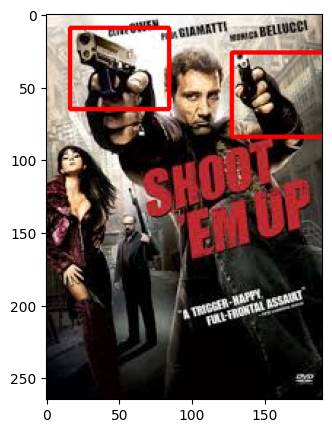

In [25]:
plot_img_bbox(torch_to_pil(img), target)

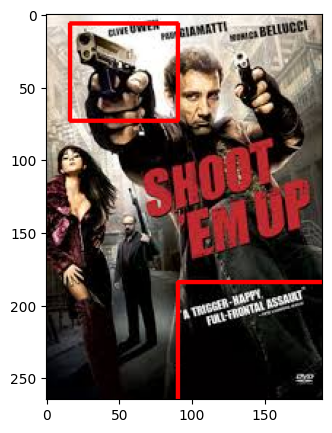

In [26]:
plot_img_bbox(torch_to_pil(img), nms_prediction)